# Bankruptcy Detection
Name:陳怡仁
Created on 2023/10/28
Uploaded on 2023/11/2

In [ ]:
!pip install bayesian-optimization
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd

from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
import itertools
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report,accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.metrics import roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier

from bayes_opt import BayesianOptimization

import shap

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


## Data Visualization

In [ ]:
data_csv = pd.read_csv('/content/drive/MyDrive/CSV原始檔/data.csv')
data_csv

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [ ]:
#重新命名所有欄位
column_names = ['Y']
column_names = column_names + ['X' + str(num) for num in range(1,len(data_csv.columns))]
column_names_df = pd.DataFrame({"Var_name": column_names,"Description": data_csv.columns})
data_csv.columns = column_names
column_names_df.style

,Var_name,Description
0,Y,Bankrupt?
1,X1,ROA(C) before interest and depreciation before interest
2,X2,ROA(A) before interest and % after tax
3,X3,ROA(B) before interest and depreciation after tax
4,X4,Operating Gross Margin
5,X5,Realized Sales Gross Margin
6,X6,Operating Profit Rate
7,X7,Pre-tax net Interest Rate
8,X8,After-tax net Interest Rate
9,X9,Non-industry income and expenditure/revenue


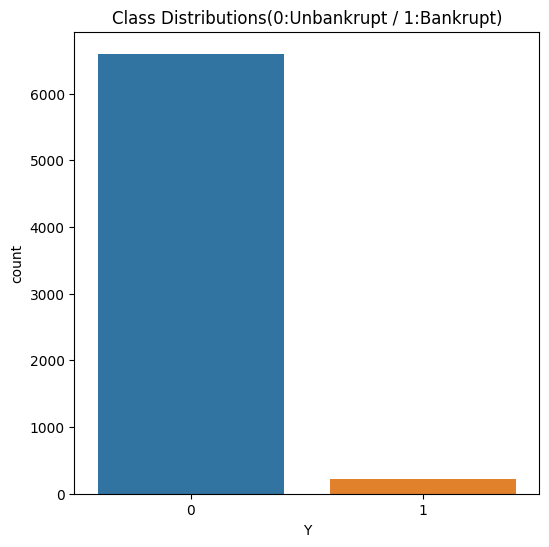

In [ ]:
#畫出倒閉與否的數量圖
plt.figure(figsize = (6,6))
sns.countplot(x = data_csv["Y"])
plt.title('Class Distributions(0:Unbankrupt / 1:Bankrupt)')
plt.show()

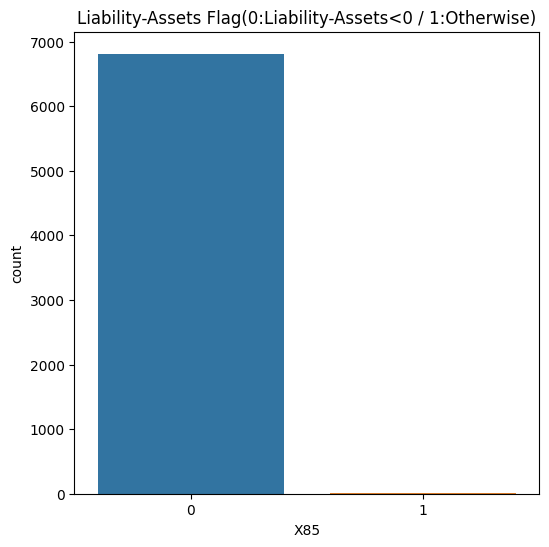

In [ ]:
#畫出Liability-Assets Flag的數量圖
plt.figure(figsize = (6,6))
sns.countplot(x = data_csv["X85"])
plt.title('Liability-Assets Flag(0:Liability-Assets<0 / 1:Otherwise)')
plt.show()

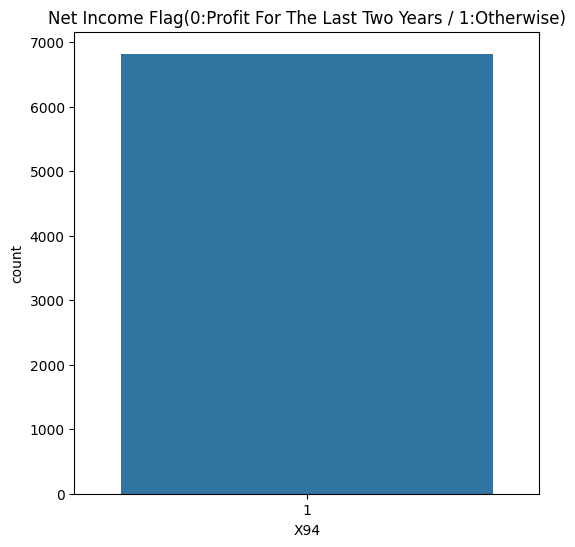

In [ ]:
#畫出Net Income Flag的數量圖
plt.figure(figsize = (6,6))
sns.countplot(x = data_csv["X94"])
plt.title('Net Income Flag(0:Profit For The Last Two Years / 1:Otherwise)')
plt.show()

In [ ]:
#列印數值為01的欄位與個數
for int_column in data_csv.select_dtypes(include="int64"):
    print(data_csv[int_column].value_counts())
    print("\n")
#X94所有數值皆為1，將它刪除
data_csv = data_csv.drop("X94",axis = "columns")

0    6599
1     220
Name: Y, dtype: int64


0    6811
1       8
Name: X85, dtype: int64


1    6819
Name: X94, dtype: int64




##Train_Test Stratified Split

In [ ]:
#切割X與y
X = data_csv.drop("Y",axis = "columns")
y = data_csv["Y"]

#Train與Test的比例為80:20
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state = 0, shuffle= True,stratify = y)

#列印Train與Test的個數
print(train_y.value_counts())
print("\n")
print(valid_y.value_counts())

0    5279
1     176
Name: Y, dtype: int64


0    1320
1      44
Name: Y, dtype: int64


##Model Metrix

##Initial Models

In [ ]:
#將Train與Test帶入模型
LogReg = LogisticRegression(random_state=0).fit(train_X, train_y)
XGBClass = xgb.XGBClassifier(eval_metric  = "logloss", max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0,
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005,seed = 0).fit(train_X,train_y)
RFClass = RandomForestClassifier(n_estimators = 50, max_depth = 50,n_jobs = -1, random_state = 0).fit(train_X,train_y)
LGBMClass = LGBMClassifier(random_state=0).fit(train_X, train_y)

[LightGBM] [Info] Number of positive: 176, number of negative: 5279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23713
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032264 -> initscore=-3.401008
[LightGBM] [Info] Start training from score -3.401008


In [ ]:
#列印結果
pred_y = LogReg.predict(valid_X)
print("                    Logistic Regression")
print(classification_report(valid_y,pred_y,digits=3))

pred_y = XGBClass.predict(valid_X)
print("                    XGBoost Classifier")
print(classification_report(valid_y,pred_y,digits=3))

pred_y = RFClass.predict(valid_X)
print("                    Random Forest Classifier")
print(classification_report(valid_y,pred_y,digits=3))

pred_y = LGBMClass.predict(valid_X)
print("                    LightGBM Classifier")
print(classification_report(valid_y,pred_y,digits=3))

                    Logistic Regression
              precision    recall  f1-score   support

           0      0.968     0.999     0.984      1320
           1      0.500     0.023     0.043        44

    accuracy                          0.968      1364
   macro avg      0.734     0.511     0.514      1364
weighted avg      0.953     0.968     0.953      1364

                    XGBoost Classifier
              precision    recall  f1-score   support

           0      0.969     1.000     0.984      1320
           1      1.000     0.045     0.087        44

    accuracy                          0.969      1364
   macro avg      0.985     0.523     0.536      1364
weighted avg      0.970     0.969     0.955      1364

                    Random Forest Classifier
              precision    recall  f1-score   support

           0      0.975     0.994     0.984      1320
           1      0.556     0.227     0.323        44

    accuracy                          0.969      1364
   m

##LightGBM CLassifier

In [ ]:
#為LightGBM的訓練和調參過程做準備
cat_features = data_csv.select_dtypes(['object']).columns.to_list()

train_lgbdata=lgb.Dataset(train_X,label=train_y, categorical_feature = cat_features,free_raw_data=False)
test_lgbdata=lgb.Dataset(valid_X,label=valid_y, categorical_feature = cat_features,free_raw_data=False)

##Bayesian Optimization

In [ ]:
## https://github.com/fmfn/BayesianOptimization
#設計貝葉斯優化過程
def search_best_param(X,y,cat_features):

    trainXY = lgb.Dataset(data=X, label=y,categorical_feature = cat_features,free_raw_data=False)

    def lightGBM_CV(max_depth, num_leaves, n_estimators, learning_rate, subsample, colsample_bytree,
                lambda_l1, lambda_l2, min_child_weight):

        params = {'boosting_type': 'gbdt', 'objective': 'binary', 'metric':'auc', 'verbose': -1,
                  'early_stopping_round':100}

        params['max_depth'] = int(round(max_depth))
        params["num_leaves"] = int(round(num_leaves))
        params["n_estimators"] = int(round(n_estimators))
        params['learning_rate'] = learning_rate
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_child_weight'] = min_child_weight

        score = lgb.cv(params, trainXY, nfold=5, seed=1, stratified=True, metrics=['auc'])
        return np.mean(score['valid auc-mean'])

    lightGBM_Bo = BayesianOptimization(lightGBM_CV,
                                       {
                                          'max_depth': (5, 50),
                                          'num_leaves': (20, 100),
                                          'n_estimators': (50, 500),
                                          'learning_rate': (0.01, 0.3),
                                          'subsample': (0.7, 0.8),
                                          'colsample_bytree' :(0.5, 0.99),
                                          'lambda_l1': (0, 5),
                                          'lambda_l2': (0, 3),
                                          'min_child_weight': (2, 50)
                                      },
                                       random_state = 1,
                                       verbose = 3
                                      )
    np.random.seed(1)

    lightGBM_Bo.maximize(init_points= 5, n_iter=5)
    params_set = lightGBM_Bo.max['params']

    max_target = -np.inf
    for i in lightGBM_Bo.res:
        if i['target'] > max_target:
            params_set = i['params']
            max_target = i['target']

    params_set.update({'verbose': -1})
    params_set.update({'metric': 'auc'})
    params_set.update({'boosting_type': 'gbdt'})
    params_set.update({'objective': 'binary'})

    params_set['max_depth'] = int(round(params_set['max_depth']))
    params_set['num_leaves'] = int(round(params_set['num_leaves']))
    params_set['n_estimators'] = int(round(params_set['n_estimators']))
    params_set['seed'] = 1

    return params_set

In [ ]:
#列印前10次迭代後的參數
best_params = search_best_param(train_X,train_y,cat_features)

|   iter    |  target   | colsam... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.9418    | 0.7043    | 3.602     | 0.0003431 | 0.09768   | 11.6      | 6.432     | 133.8     | 47.64     | 0.7397    |
| 2         | 0.9401    | 0.764     | 2.096     | 2.056     | 0.06929   | 44.52     | 3.315     | 351.7     | 53.38     | 0.7559    |
| 3         | 0.9366    | 0.5688    | 0.9905    | 2.402     | 0.2908    | 19.1      | 35.23     | 444.4     | 91.57     | 0.7085    |
| 4         | 0.9281    | 0.5191    | 0.8492    | 2.634     | 0.03852   | 23.95     | 47.98     | 289.9     | 75.35     | 0.7316    |
| 5         | 0.9367    | 0.8364    | 4.173     | 0.05486   | 0.2275    | 49.5      | 37.91     | 176.2     | 83.14     | 0.7103    |
| 6         | 0.9357    | 0.6843    | 3.497     | 0.9324    | 

In [ ]:
#列印最大的Target的所有參數，也就是最佳參數
for key, value in best_params.items():
    print(key, ' : ', value)

colsample_bytree  :  0.7043407823042612
lambda_l1  :  3.6016224672107904
lambda_l2  :  0.0003431244520346599
learning_rate  :  0.09767644606323352
max_depth  :  12
min_child_weight  :  6.432252548902294
n_estimators  :  134
num_leaves  :  48
subsample  :  0.739676747423067
verbose  :  -1
metric  :  auc
boosting_type  :  gbdt
objective  :  binary
seed  :  1


##Tuning LightGBM

In [ ]:
#將最佳參數帶入LightGBM模型
lgbm_best = lgb.train(best_params,
                 train_lgbdata,
                 num_boost_round = 100,
                 valid_sets = test_lgbdata
                 )

##Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

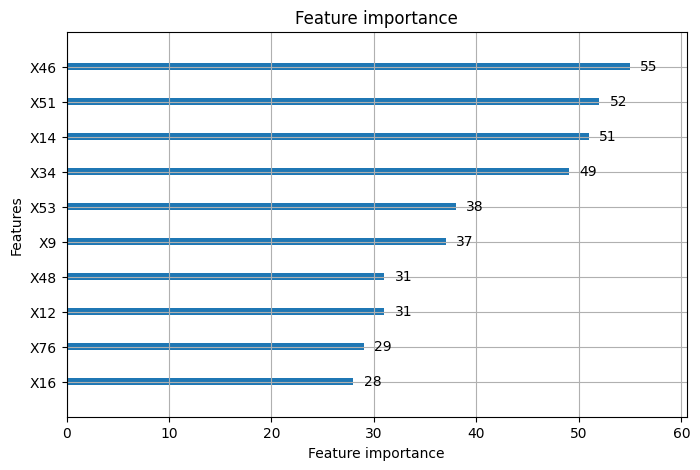

In [ ]:
#畫出帶入最佳參數後，重要度前10名的欄位
lgb.plot_importance(lgbm_best,figsize=(8,5),max_num_features = 10)

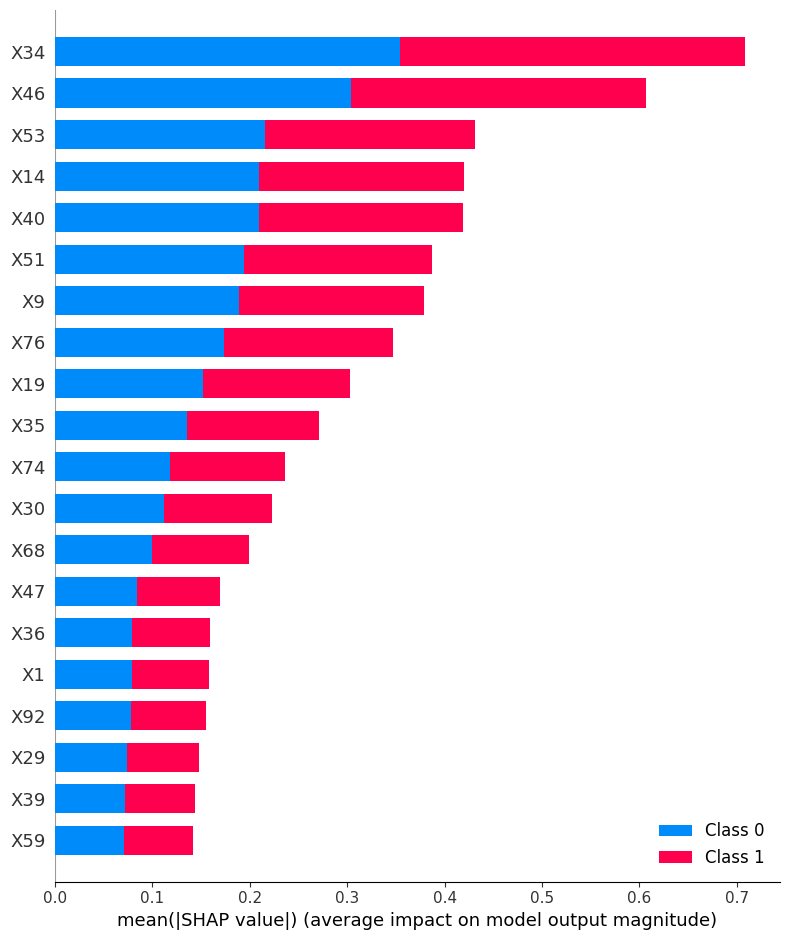

In [ ]:
#列印這10個欄位的shap值
shap_values = shap.TreeExplainer(lgbm_best).shap_values(valid_X)
shap.summary_plot(shap_values, valid_X)

##LIghtGBM Model Performance

##ROC Curve

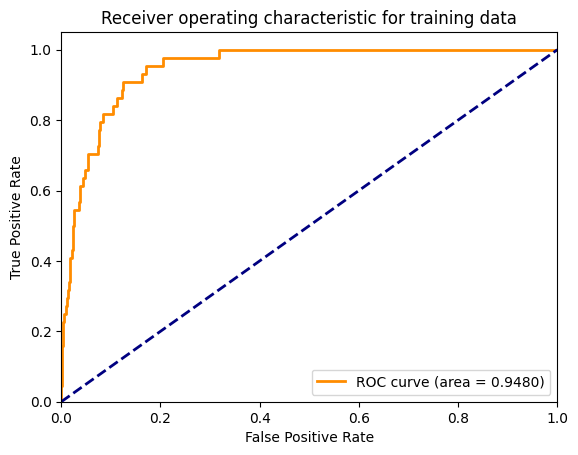

In [ ]:
y_probas = lgbm_best.predict(valid_X)

fpr, tpr, _ = roc_curve(valid_y, y_probas)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for training data')
plt.legend(loc="lower right")
plt.show()

Best Threshold=0.021575, G-Mean=0.893


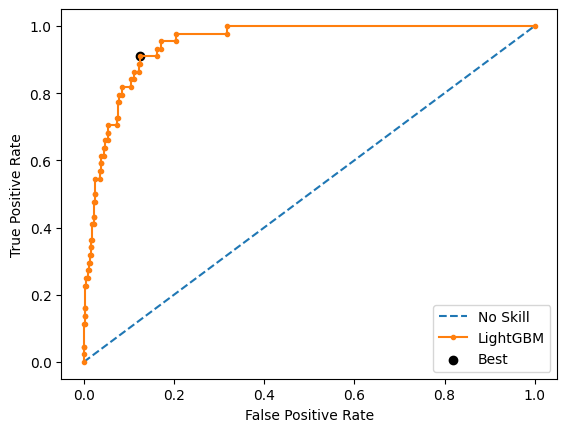

In [ ]:
pred_y = lgbm_best.predict(valid_X)

fpr, tpr, thresholds = roc_curve(valid_y, pred_y)

gmeans = np.sqrt(tpr * (1-fpr))

ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

pyplot.figure(num=0, figsize=[6.4, 4.8])
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='LightGBM')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

pyplot.show()

##Confusion Matrix

In [ ]:
# https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
#設計混淆矩陣的輸出函式
def plot_confusion_matrix_kaggle(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def binarizeArray(array,threshold = 0.5):
    return [0 if num < threshold else 1 for num in array]

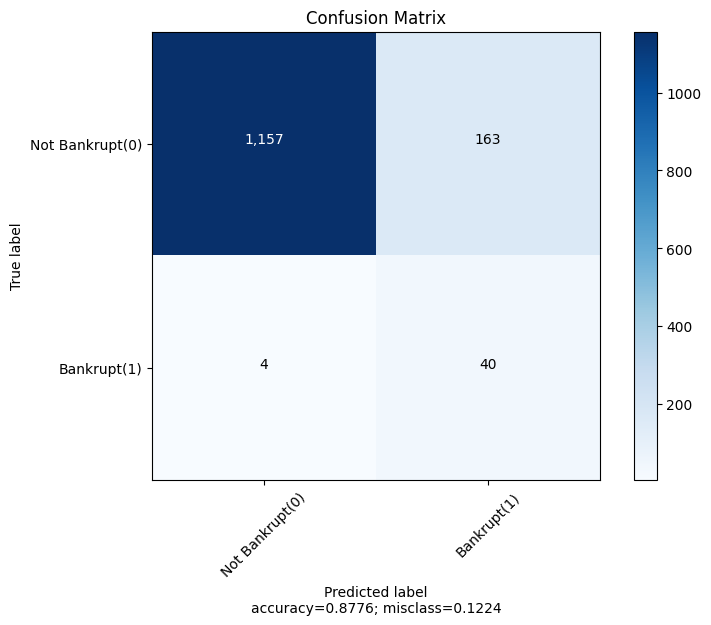

              precision    recall  f1-score   support

           0       1.00      0.88      0.93      1320
           1       0.20      0.91      0.32        44

    accuracy                           0.88      1364
   macro avg       0.60      0.89      0.63      1364
weighted avg       0.97      0.88      0.91      1364

Accuracy: 87.76%
Recall: 90.91%


In [ ]:
#畫出混淆矩陣與結果
pref_y_bin = binarizeArray(pred_y,thresholds[ix])
cm = confusion_matrix(valid_y,pref_y_bin)
plot_confusion_matrix_kaggle(cm =cm,
                      normalize    = False,
                      target_names = ['Not Bankrupt(0)', 'Bankrupt(1)'],
                      title        = "Confusion Matrix")
print(classification_report(valid_y,pref_y_bin))
print("Accuracy: %.2f%%" % (accuracy_score(valid_y, pref_y_bin)*100.0))
print("Recall: %.2f%%" % ((recall_score(valid_y,pref_y_bin))*100.0))